In [1]:
import sys
import os
import pandas as pd
import numpy as np
from dotenv import find_dotenv, load_dotenv
load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
#import heat_demand_estimation_gas_boilers as gasmod
#import heat_demand_estimation_clustered_LAs_REMA as REMA
import heat_demand_estimation_clustered_LAs_REMA_FES as RFS

In [2]:
# Uncomment the following lines of codes if you want to re-extract the tempreature data
# import meteostat_tempreature as mt
# import meteostat_tempreature_ZM as Zmt

# Mapping the GSPs with HPs to PyPSA-GB Transmission Nodes
Mapping the GSPs with heat pumps excluding connected to the dsitrict heating network (DHN) in the FES 2022 to the nearest electricty tranmision nodes in the PyPSA-GB (In this study, K-means clustering with the 29 nodes as a centroid is considered to map the GSP coordinates to the nearest centroids).


In [3]:
gsp_hps=pd.read_csv('data/FES 2022 HPs.csv',encoding='latin1')

In [4]:
# find the coordinates for GSP and the coordinates of the centroid which are the coordinates of the Electricity bus
GSP_HPs=[]
for i in range (len(gsp_hps)):
    GSP_HPs_coordinates=GSP_HPs.append([gsp_hps.iloc[i]['Latitude'],gsp_hps.iloc[i]['Longitude']])
    GSP_HPs_coordinates=np.asarray(GSP_HPs)

In [5]:
modell='zonal'
#modell='reduced'

In [6]:
if modell=='zonal':
    df_network = pd.read_csv('data/buses_ZM.csv')
    gb_nodes=[]
    for i in range(len(df_network)):
        heat_node_centroids=gb_nodes.append([df_network.iloc[i]['y'],df_network.iloc[i]['x']])
else:
   df_network = pd.read_csv('data/buses.csv') 
   gb_nodes=[]
   for i in range(len(df_network[:29])):
       heat_node_centroids=gb_nodes.append([df_network.iloc[i]['y'],df_network.iloc[i]['x']])

heat_node_centroids=np.array(gb_nodes)


In [7]:
df_network

,name,y,x,v_nom,carrier
0,Z10,53.136,-0.3830,400,AC
1,Z11,52.569,-1.6470,400,AC
2,Z12,52.254,0.4507,400,AC
3,Z13,51.817,-2.9460,400,AC
4,Z14,51.536,-0.1570,400,AC
5,Z15,51.312,0.8260,400,AC
6,Z16,51.039,-0.7250,400,AC
7,Z17,50.757,-3.6010,400,AC
8,Z1_1,60.377,-1.2400,400,AC
9,Z1_2,57.944,-6.8340,400,AC


In [8]:
# Apply the k means clustering to mapp the GSP to the nodes in the PyPSA GB
kmeans = KMeans(n_clusters=len(heat_node_centroids), init=heat_node_centroids, n_init=1)
clusters=kmeans.fit_predict(GSP_HPs_coordinates)

C:\Users\salene\Anaconda3\envs\REMA\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [9]:
# include the cluster column in the gsp_hps dataframe
gsp_hps['cluster']=clusters

Let us create a dictionary for each cluster, the keys for the dictionary represents the GSP name across GB and the values for the values for the dictionary represents the number of HPs for the year 2022 for that particlar GSPs in the future energy scenario FES 2022 data. If the number of HPs installed in the GSPs for a different year is required the value 2022 in the below code can be changed to the desired year accordingly.

In [10]:
# create a dictionary
cluster_dictionaries = {}
for cls, group in gsp_hps.groupby('cluster'):
    cluster_dict = {}
    for _, row in group.iterrows():
        gsp_name = row['GSP']
        value_2035 = row['2035']
        cluster_dict[gsp_name] = value_2035
    cluster_dictionaries[cls] = cluster_dict

# if we want to access a specific cluster dictionary
cluster_0_dict = cluster_dictionaries[0]
cluster_0_dict

{'Creyke Beck': 80918.3,
 'Grimsby West': 27634.6,
 'Keadby': 44229.5,
 'Saltend North': 11606.3,
 'West Melton': 55777.4,
 'Bicker Fen': 32605.6,
 'Staythorpe': 30673.8,
 'Stoke Bardolph': 37751.2,
 'West Burton': 37942.7}

In [11]:
# Let us create the sum of hps in each dictionary (cluster)
cluster_sums_hps = []
# Iterate over each cluster dictionary
for cluster_dict in cluster_dictionaries.values():
    # Calculate the sum of values in the current cluster dictionary
    cluster_sum = sum(cluster_dict.values())
    cluster_sums_hps.append(cluster_sum)
#cluster_sums_hps       #  the number of heat pumps in each cluster for the year 2020 from the future energy scenario data

# Mapping the GSPs with DHN to PyPSA-GB Transmission Nodes

Mapping the GSPs which are connected to the district heating network (DHN) in the FES 2022 to the nearest electricty tranmision nodes in the PyPSA-GB (In this study, K-means clustering with the 29 nodes as a centroid is considered to map the GSP coordinates to the nearest centroids).

In [12]:
gsp_dhn=pd.read_csv('data/FES 2022 DHN.csv',encoding='latin1')

In [13]:
# find the coordinates for GSP with the DHN and the coordinates of the centroid which are the coordinates of the Electricity bus
GSP_DHN=[]
for i in range (len(gsp_dhn)):
    GSP_DHN_coordinates=GSP_DHN.append([gsp_dhn.iloc[i]['Latitude'],gsp_hps.iloc[i]['Longitude']])
    GSP_DHN_coordinates=np.asarray(GSP_DHN)

In [14]:
# Apply the k means clustering to mapp the GSP with DHN to the nodes in the PyPSA GB
kmeans = KMeans(n_clusters=len(heat_node_centroids), init=heat_node_centroids, n_init=1)
clusters=kmeans.fit_predict(GSP_DHN_coordinates)

C:\Users\salene\Anaconda3\envs\REMA\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [15]:
#similarily, include the cluster column in the gsp_dhn dataframe
gsp_dhn['cluster']=clusters
gsp_dhn

,FES Scenario,Building Block ID Number,Unit,DNO License Area,GSP,Latitude,Longitude,2021,2022,2023,...,2043,2044,2045,2046,2047,2048,2049,2050,Comment,cluster
0,Leading the Way,Lct_BB009,Number,East Midlands,Berkswell,55.777424,-2.078700,4308.3,4431.6,4593.1,...,27443.9,28911.9,30129.4,29241.5,30133.8,31023.2,31851.7,32051.0,NaN,17
1,Leading the Way,Lct_BB009,Number,East Midlands,Bicker Fen,52.930800,-0.221164,3394.4,3487.4,3618.3,...,22384.9,23582.2,24574.6,23902.1,24632.9,25359.5,26038.2,26201.0,NaN,1
2,Leading the Way,Lct_BB009,Number,East Midlands,Chesterfield,53.224282,-1.387486,3978.1,4091.3,4240.5,...,23913.1,25192.8,26253.0,26174.7,26972.1,27769.4,28511.3,28689.6,NaN,1
3,Leading the Way,Lct_BB009,Number,East Midlands,Coventry,52.455529,-1.463957,4354.4,4474.1,4641.9,...,27725.1,29207.2,30437.8,29539.5,30442.1,31341.1,32177.6,32378.8,NaN,1
4,Leading the Way,Lct_BB009,Number,East Midlands,Drakelow,52.773204,-1.649460,3425.1,3521.4,3649.8,...,22152.4,23336.4,24319.7,23656.5,24377.4,25098.2,25767.5,25928.6,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,Leading the Way,Lct_BB009,Number,West Midlands,Penn,52.556484,-2.208345,3210.1,3304.5,3426.2,...,21112.6,22241.4,23178.6,22536.5,23225.1,23911.5,24549.3,24702.8,NaN,1
362,Leading the Way,Lct_BB009,Number,West Midlands,Rugeley,52.753784,-1.912625,3432.8,3529.9,3658.4,...,22180.7,23368.3,24352.2,23735.1,24458.2,25181.4,25854.4,26016.1,NaN,2
363,Leading the Way,Lct_BB009,Number,West Midlands,Shrewsbury,52.709666,-2.692681,3494.3,3593.7,3727.3,...,22593.8,23802.5,24805.1,24175.5,24913.1,25650.7,26335.6,26500.3,NaN,2
364,Leading the Way,Lct_BB009,Number,West Midlands,Walham,51.871635,-2.266206,4262.2,4384.8,4547.2,...,26372.7,27783.4,28954.1,28056.0,28912.3,29766.6,30561.7,30752.8,NaN,6


In [16]:
# create a dictionary, number of dwellings for the year 2022 as a value
cluster_dhn_dictionaries = {}
for cls, group in gsp_dhn.groupby('cluster'):
    cluster_dict = {}
    for _, row in group.iterrows():
        gsp_name = row['GSP']
        value_2035 = row['2035']
        cluster_dict[gsp_name] = value_2035
    cluster_dhn_dictionaries[cls] = cluster_dict

# if we want to access a specific cluster dictionary
cluster_0_dict = cluster_dhn_dictionaries[0]
cluster_0_dict

{'Staythorpe': 12320.1,
 'Carrington': 4524.2,
 'Heysham (Barrow WF)': 122.4,
 'Kearsley 33kV': 1453.6,
 'Kirkby (_G)': 4417.2,
 'Macclesfield': 14284.5,
 'Ormonde': 555.8,
 'Rochdale': 3067.7,
 'South Manchester': 7766.4,
 'Stalybridge': 13614.7,
 'Walney 2': 436.2,
 'Washway Farm': 3996.5,
 'Whitegate': 4498.8,
 'Walpole (_A)': 11579.9,
 'Grimsby West': 4785.9,
 'Birkenhead': 5004.0,
 'Capenhurst': 5181.3,
 'Fiddlers Ferry': 7963.4,
 'Frodsham': 15102.1,
 'Kirkby (_D)': 4472.1,
 'Lister Drive': 4861.9,
 'Rainhill': 4263.8,
 'Trawsfynydd': 1052.6,
 'Bushbury': 11477.2}

In [17]:
# Let us create the sum of dwellings connected to DHN in each dictionary (cluster)
cluster_sums_dhn = []
# Iterate over each cluster dictionary
for cluster_dict in cluster_dhn_dictionaries.values():
    # Calculate the sum of values in the current cluster dictionary
    cluster_sum = sum(cluster_dict.values())
    cluster_sums_dhn.append(cluster_sum)
#cluster_sums_dhn       #  the number of heat pumps in each clustered local authority for the year 2022 from the future energy scenario data

# Total Number of Dwellings Per Clusterd Local Authority Area
The total number of dwelling in each clustered local authority area is obtaied from three websites, for the local authority areas in the scotalnd area is from https://statistics.gov.scot/slice?dataset=http%3A%2F%2Fstatistics.gov.scot%2Fdata%2Fmid-year-household-estimates&http%3A%2F%2Fpurl.org%2Flinked-data%2Fsdmx%2F2009%2Fdimension%23refPeriod=http%3A%2F%2Freference.data.gov.uk%2Fid%2Fyear%2F2021,
and for the local authorities in the England area is from https://commonslibrary.parliament.uk/local-authority-data-housing-supply/, and similarily for the local authority ares in Wales are obtained from https://statswales.gov.wales/Catalogue/Housing/Households/Estimates/households-by-localauthority-year. The following link is used to map the node location to the council area/local authority area https://findthatpostcode.uk/. We have used the latitude and and longitude of the nodes to find the local authority which can model the aggregate heat demand of the area.

In [18]:
# the total number of dwellings in each cluster obtained from 
ndgs_cluster0={'Highland':110743}
ndgs_cluster1={
    'Aberdeen City':108844,
    'Aberdeenshire':113861
}
ndgs_cluster2={
    'Moray':43590,
    'Perth and Kinross':70315
              }
ndgs_cluster3={
    'Clackmannanshire':24077,
    'Falkirk':73375,
    'City of Edinburgh':241658,
    'West Lothian':80932,
    'North Lanarkshire':153643
}
ndgs_cluster4={
    'East Renfrewshire':40081,
    'Inverclyde':37958,
    'North Ayrshire':64886,
    'South Ayrshire':52753,
    'Stirling':40174,
    'Argyll and Bute':42384,
    'Renfrewshire':87910,
    'West Dunbartonshire':43364,
    'East Dunbartonshire':46849,
    'Glasgow City': 298847   
}

ndgs_cluster5={
    'Dumfries and Galloway':70405,
    'East Ayrshire':56149,
    'South Lanarkshire':149864,    
}
ndgs_cluster6={
    'East Lothian':48400,
    'Midlothian':40876,
    'Scottish Borders':55296,
    'Angus':42384,
    'Dundee City':71224,
    'Fife':171086,   
}


ndgs_cluster7={
    'Northumberland':159916,
      
}
ndgs_cluster8={
    'Allerdale':48314,
    'Barrow-in-Furness':33707,
    'Carlisle':54758,
    'Copeland':33705,
    'Eden':27453,
    'South Lakeland':56295,   
}
ndgs_cluster9={
    'Hartlepool':44666,
    'Middlesbrough':64362,
    'Stockton-on-Tees':88607,
    'Darlington':52397,
    'County Durham':246445,
    'Richmondshire':24347, 
    'Newcastle upon Tyne':134325,
    'North Tyneside':100611,
    'South Tyneside':72535,
    'Sunderland':130022,
    'Gateshead':94950  
}
ndgs_cluster10={
    'Halton':59327,
    'Warrington':93631,
    'Blackpool':70683,
    'Cheshire West and Chester':163258,
    'Chorley':52563,
    'Fylde':40746, 
    'Lancaster':64641,
    'Preston':65756,
    'South Ribble':50995,
    'West Lancashire':51278,
    'Wyre':53346, 
    'Wigan':149783,
    'Knowsley':68426,
    'Liverpool':233867,
    'St. Helenes':84747,
    'Sefton':128400,
    'Wirral':150300,
    'Flinshire':66973,
    'Wrexham':59058,
    
}

ndgs_cluster11={
    'Isle of Anglesey':31555,
    'Gwynedd':55123,
    'Conwy':53351,
    'Denbighshire':42220,
    'Ceredigion':31413,
    'Carmarthenshire':82897,
    'Powys':60240   
}
ndgs_cluster12={
    'Blackburn with Darwen': 62074,
    'Stoke-on-Trent': 117690, 
    'Cheshire East': 163258, 
    'High Peak': 43183, 
    'Burnley': 41479, 
    'Hyndburn': 37233,
    'Pendle': 40918, 
    'Ribble Valley':28360, 
    'Rossendale': 32332, 
    'Craven': 28999, 
    'Newcastle-under-Lyme': 57657,
    'Staffordshire Moorlands': 45068, 
    'Bolton':125454, 
    'Bury': 84508, 
    'Manchester': 235024, 
    'Oldham': 96645,
    'Rochdale': 94873, 
    'Salford': 126281, 
    'Stockport': 131488, 
    'Tameside': 103835, 
    'Trafford': 101840, 
    'Bradford': 217892, 
    'Calderdale': 96096
}
ndgs_cluster13={
    'Bolsover': 37039, 
    'Chesterfield': 5027,
    'Derbyshire Dales': 35999, 
    'North East Derbyshire': 46888,
    'Harrogate': 74934, 
    'Barnsley': 113022, 
    'Doncaster': 139758, 
    'Rotherham': 117521, 
    'Sheffield': 253737, 
    'Kirklees': 191334, 
    'Leeds': 356807, 
    'Wakefield': 160281
}
ndgs_cluster14={
    'Redcar and Cleveland': 65393,
    'York':91209, 
    'Hambleton': 43676, 
    'Ryedale':27436, 
    'Scarborough': 60259, 
    'Selby': 40877
}

ndgs_cluster15={
    'Kingston upon Hull, City of': 122723,
    'East Riding of Yorkshire': 163065, 
    'North East Lincolnshire': 75511, 
    'North Lincolnshire': 77262, 
    'Lincoln': 44900, 
    'North Kesteven': 52600, 
    'West Lindsey': 43722, 
    'Bassetlaw': 53651
}

ndgs_cluster16={
    'Derby': 111766, 
    'Leicester': 139614, 
    'Rutland': 17869, 
    'Nottingham': 141884, 
    'Amber Valley':59087, 
    'Erewash':52840, 
    'South Derbyshire': 47677,
    'Blaby': 44251,
    'Charnwood': 77466, 
    'Harborough': 41771, 
    'Hinckley and Bosworth': 51303, 
    'Melton': 23829, 
    'North West Leicestershire': 46969, 
    'Oadby and Wigston': 23644, 
    'Ashfield': 56760, 
    'Broxtowe': 50459, 
    'Gedling': 53563, 
    'Mansfield': 49962, 
    'Newark and Sherwood': 55759, 
    'Rushcliffe': 51838, 
    'Nuneaton and Bedworth':58417, 
    'Rugby': 48816
}

ndgs_clusetr17={
    'Telford and Wrekin': 78590, 
    'Shropshire': 149250, 
    'Cheltenham': 56943, 
    'Cotswold':45628, 
    'Gloucester': 57783, 
    'Stroud': 55054, 
    'Tewkesbury': 43327, 
    'West Oxfordshire': 50874, 
    'Cannock Chase': 45012, 
    'East Staffordshire': 54084,
    'Lichfield': 47054, 
    'South Staffordshire': 48064, 
    'Stafford': 63509, 
    'Tamworth':34263, 
    'North Warwickshire': 28858, 
    'Stratford-on-Avon': 63548, 
    'Warwick': 66909, 
    'Bromsgrove': 42059, 
    'Malvern Hills': 37109, 
    'Redditch': 37676, 
    'Worcester':46599, 
    'Wychavon': 59772, 
    'Wyre Forest': 47499, 
    'Birmingham': 448812, 
    'Coventry': 144939, 
    'Dudley': 140519, 
    'Sandwell':133739, 
    'Solihull': 93724, 
    'Walsall': 117008, 
    'Wolverhampton': 112202
}

ndgs_cluster18={
    'Peterborough': 86789,
    'Fenland': 45998, 
    'Huntingdonshire':78943, 
    'Boston': 30755, 
    'East Lindsey': 69034, 
    'South Holland': 42307, 
    'South Kesteven': 64926, 
    "King's Lynn and West Norfolk": 78214
}
ndgs_cluster19={
    'Colchester': 83268, 
    'Tendring': 71688,
    'Breckland': 62845, 
    'Broadland': 60024, 
    'Great Yarmouth': 46841, 
    'North Norfolk': 57497, 
    'Norwich': 67104,
    'South Norfolk': 63713, 
    'Babergh': 42064, 
    'Ipswich': 62097, 
    'Mid Suffolk': 46594,
    'East Suffolk': 119573, 
    'West Suffolk': 81290
}

ndgs_cluster20={
    'Cambridge': 56091, 
    'East Cambridgeshire': 38710,
    'South Cambridgeshire': 70014, 
    'Braintree': 67342, 
    'Brentwood': 33925, 
    'Chelmsford': 78724,
    'Epping Forest':57186, 
    'Harlow': 39358, 
    'Uttlesford': 38833, 
    'Broxbourne': 41368, 
    'North Hertfordshire': 58497,
    'East Hertfordshire': 64771, 
    'Stevenage': 37828, 
    'Havering': 103453
}

ndgs_cluster21={
    'Luton': 81289, 
    'Milton Keynes': 117306, 
    'Bedford': 77884, 
    'Central Bedfordshire': 126104, 
    'Buckinghamshire': 230039, 
    'North Northamptonshire': 153857,
    'West Northamptonshire': 176807, 
    'Dacorum': 66990, 
    'Cherwell': 68826, 
    'Oxford': 59843, 
    'South Oxfordshire': 64511
}

ndgs_cluster22={
    'Herefordshire, County of': 87547, 
    'Bath and North East Somerset': 84019, 
    'Bristol, City of': 203561, 
    'North Somerset': 99019, 
    'South Gloucestershire': 123113, 
    'Dorset': 183455, 
    'East Devon': 72105, 
    'Forest of Dean': 39144, 
    'Mendip': 53113, 
    'Sedgemoor': 56222, 
    'South Somerset': 79838, 
    'Somerset West and Taunton': 73945, 
    'Neath Port Talbot': 62768,
    'Bridgend': 63152, 
    'Vale of Glamorgan': 58879, 
    'Cardiff': 156264, 
    'Rhondda Cynon Taf': 106316, 
    'Caerphilly': 31371,
    'Blaenau Gwent': 31371, 
    'Torfaen': 40813, 
    'Monmouthshire': 40712, 
    'Newport': 66543, 
    'Merthyr Tydfil': 24974}

ndgs_cluster23={
    'Bracknell Forest': 52915,
    'Reading': 71305, 
    'Slough': 56773, 
    'Windsor and Maidenhead': 65214, 
    'Wokingham': 71109, 
    'East Hampshire':54804, 
    'Hart': 41307, 
    'Rushmoor': 40822, 
    'Guildford': 59705, 
    'Runnymede':37095, 
    'Spelthorne': 43602, 
    'Surrey Heath':37163, 
    'Waverley':55029, 
    'Woking': 43270, 
    'Adur': 28730, 
    'Arun': 276423, 
    'Chichester': 58695,
    'Horsham': 65199, 
    'Worthing': 51324
}

ndgs_cluster24={
    'Brighton and Hove': 129321,
    'Lewes': 46449, 
    'Hertsmere': 45240, 
    'Three Rivers': 38229, 
    'Watford': 40836, 
    'Elmbridge': 58548, 
    'Epsom and Ewell': 32880,
    'Mole Valley': 39206, 
    'Reigate and Banstead': 62233, 
    'Tandridge': 36923, 
    'Crawley': 47179,
    'Mid Sussex': 66601, 
    'St Albans': 62000, 
    'Welwyn Hatfield': 48881, 
    'City of London': 7305, 
    'Barking and Dagenham': 77618, 
    'Barnet': 157186, 
    'Bexley': 99231, 
    'Brent': 125285, 
    'Bromley': 140441, 
    'Camden': 107092, 
    'Croydon': 164746, 
    'Ealing': 138794, 
    'Enfield': 127472, 
    'Greenwich': 118492, 
    'Hackney': 113174,
    'Hammersmith and Fulham': 91756,
    'Haringey': 111685, 
    'Harrow': 93884, 
    'Hillingdon': 113098, 
    'Hounslow': 105106, 
    'Islington': 105148, 
    'Kensington and Chelsea': 88504,
    'Kingston upon Thames': 68734, 
    'Lambeth': 144222, 
    'Lewisham': 129547, 
    'Merton': 85559,
    'Newham': 122160, 
    'Redbridge': 107753, 
    'Richmond upon Thames': 87239, 
    'Southwark': 138732, 
    'Sutton': 84439, 
    'Tower Hamlets': 129351, 
    'Waltham Forest': 105820, 
    'Wandsworth': 150805, 
    'Westminster': 127002
}

ndgs_cluster25={
    'Southend-on-Sea': 81652, 
    'Thurrock': 68785, 
    'Medway': 117366,
    'Eastbourne': 49355,
    'Hastings': 44647, 
    'Rother': 46024, 
    'Wealden': 71787, 
    'Basildon': 78809, 
    'Castle Point': 39073, 
    'Maldon':29451, 
    'Rochford': 36676,
    'Ashford': 56200, 
    'Dartford': 48455, 
    'Gravesham': 43973, 
    'Maidstone': 74866, 
    'Sevenoaks': 51163, 
    'Swale': 63379, 
    'Tonbridge and Malling': 56096, 
    'Tunbridge Wells': 52503
}
ndgs_cluster26={
    'Canterbury': 69135, 
    'Dover': 55439, 
    'Folkestone and Hythe': 53217, 
    'Thanet': 68400
}

ndgs_cluster27={
    'Swindon': 100269, 
    'West Berkshire': 69438, 
    'Portsmouth': 91230, 
    'Southampton': 109201, 
    'Isle of Wight': 71426, 
    'Wiltshire': 224194, 
    'Bournemouth, Christchurch and Poole':186252, 
    'Basingstoke and Deane': 78761, 
    'Eastleigh': 59745, 
    'Fareham': 50602, 
    'Gosport': 38118, 
    'Havant': 56340, 
    'New Forest': 82991, 
    'Test Valley': 57093, 
    'Winchester': 54180, 
    'Vale of White Horse': 61088
}

ndgs_cluster28={
    'Plymouth': 120780, 
    'Torbay': 67301, 
    'Cornwall': 286175, 
    'Isles of Scilly': 1406, 
    'Exeter': 57096, 
    'Mid Devon': 37577, 
    'North Devon':49182, 
    'South Hams': 46933, 
    'Teignbridge': 63723, 
    'Torridge': 33387, 
    'West Devon': 26300, 
    'Pembrokeshire': 56647,
    'Swansea': 109714
}

In [19]:
# list the 29 clusters 
ndgs_clusters=[
    ndgs_cluster0,
    ndgs_cluster1,
    ndgs_cluster2,
    ndgs_cluster3,
    ndgs_cluster4,
    ndgs_cluster5,
    ndgs_cluster6,
    ndgs_cluster7,
    ndgs_cluster8,
    ndgs_cluster9,
    ndgs_cluster10,
    ndgs_cluster11,
    ndgs_cluster12,
    ndgs_cluster13,
    ndgs_cluster14,
    ndgs_cluster15,
    ndgs_cluster16,
    ndgs_clusetr17,
    ndgs_cluster18,
    ndgs_cluster19,
    ndgs_cluster20,
    ndgs_cluster21,
    ndgs_cluster22,
    ndgs_cluster23,
    ndgs_cluster24,
    ndgs_cluster25,
    ndgs_cluster26,
    ndgs_cluster27,
    ndgs_cluster28,
]

# find the total number of buildings per cluster
bdgs_per_cluster = []

for i in range(29):
    ndgs_i = sum(ndgs_clusters[i].values())
    bdgs_per_cluster.append(ndgs_i)
    
bdgs_per_cluster    

[110743,
 222705,
 113905,
 573685,
 755206,
 276418,
 429266,
 159916,
 254232,
 1053267,
 1707778,
 356799,
 2112187,
 1532347,
 328850,
 633434,
 1305544,
 2450407,
 496966,
 864598,
 786100,
 1223456,
 1838244,
 1210484,
 4321906,
 1110260,
 246191,
 1390928,
 956221]

In [20]:
if modell=='reduced':
 bdgs_per_cluster   [110743,
 222705,
 113905,
 573685,
 755206,
 276418,
 429266,
 159916,
 254232,
 1053267,
 1707778,
 356799,
 2112187,
 1532347,
 328850,
 633434,
 1305544,
 2450407,
 496966,
 864598,
 786100,
 1223456,
 1838244,
 1210484,
 4321906,
 1110260,
 246191,
 1390928,
 956221
    ]
elif modell=='zonal':
    bdgs_per_cluster=[1194090,
 2857825,
 1048864,
 1488942,
 6036795,
 1489434,
 2237691,
 934504,
 1406,
 657000,
 182249,
 110743,
 379903,
 987286,
 197981,
 806015,
 318873,
 1484881,
 2610677,
 3677021]

# Using the FES and CLA Dwelling Estimation Data
Using the future energy data,substract the number of heat pumps from the total number of dwellings obtained from CLAs.

In [21]:
ndgs_fes_hps=cluster_sums_hps   # then the rest of the dwellings are asuumed to be supplied from gas boilers and district heat networks
ndgs_fes_dhn=cluster_sums_dhn
#
ndgs_CLA=bdgs_per_cluster

ndgs_fes_gas_dhn=[]
for i in range(len(bdgs_per_cluster)):
    if ndgs_CLA[i]>ndgs_fes_hps[i]:
        gs_dn=np.subtract(ndgs_CLA[i],ndgs_fes_hps[i])
        ndgs_fes_gas_dhn.append(gs_dn)
    else:
        gs_dn=ndgs_fes_dhn[i]
        ndgs_fes_gas_dhn.append(gs_dn)
        
ndgs_fes_gas=abs(np.subtract(np.array(ndgs_fes_gas_dhn),np.array(ndgs_fes_dhn)))
ndgs_fes_gas=ndgs_fes_gas.tolist()

In [22]:
hp_nominal=0.12     #MW
central_hps_nomcap=[x* hp_nominal for x in ndgs_fes_hps]

In [23]:
# Let us disaggregate the number of dwellings to the ASHP and GSHP installed ones using a 75 to 25 proportion.
k1=0.75
k2=0.25
ndgs_fes_hps_ashp = [x * k1 for x in ndgs_fes_hps]
ndgs_fes_hps_gshp=[x * k2 for x in ndgs_fes_hps]


In [24]:
if modell=='reduced':
    heat_node=[
    'beauly',
    'peterhead',
    'errochty',
    'denny_bonny',
    'neilston',
    'strathaven', 
    'torness',
    'eccles',
    'harker',
    'stella_west',
    'penwortham',
    'deeside',
    'daines',
    'marsh_stocksbridge',
    'thornton_drax_eggborough',
    'keadby',
    'ratcliffe',
    'feckenham',
    'walpole',
    'bramford',
    'pelham',
    'sundon_east_claydon',
    'melksham',
    'bramley',
    'london',
    'kemsley',
    'sellindge',
    'lovedean',
    's_w_penisula'
          ]
elif modell=='zonal':
    heat_node=[
    'Z10',
    'Z11',
    'Z12',
    'Z13',
    'Z14',
    'Z15', 
    'Z16',
    'Z17',
    'Z1_1',
    'Z1_2',
    'Z1_3',
    'Z1_4',
    'Z2',
    'Z3',
    'Z4',
    'Z5',
    'Z6',
    'Z7',
    'Z8',
    'Z9'
    ]

#ndgs=bdgs_per_cluster

Call the modules for hourly heat demand and HP COP profile estimations for the FES years

In [25]:
fes_year='2035'
RFS.hourly_heat_temp_RHPP(heat_node,ndgs_fes_hps,fes_year,modell)
#RFS.hourly_heat_temp_EDRP(heat_node,ndgs_fes_gas,fes_year)
#RFS.hourly_heat_temp_EDRP_DHN(heat_node,ndgs_fes_dhn,fes_year)


In [26]:
df_heat_beauly_total=pd.read_csv('data/domestic_EDRP/2035/scaled with normalised profiles/hourly heat demand total_beauly.csv', index_col=0)

In [27]:
df_heat_errochty_total=pd.read_csv('data/domestic_EDRP/2035/scaled with normalised profiles/hourly heat demand total_peterhead.csv', index_col=0)

Text(0, 0.5, 'Ambient tempreature(in degree celcius)')

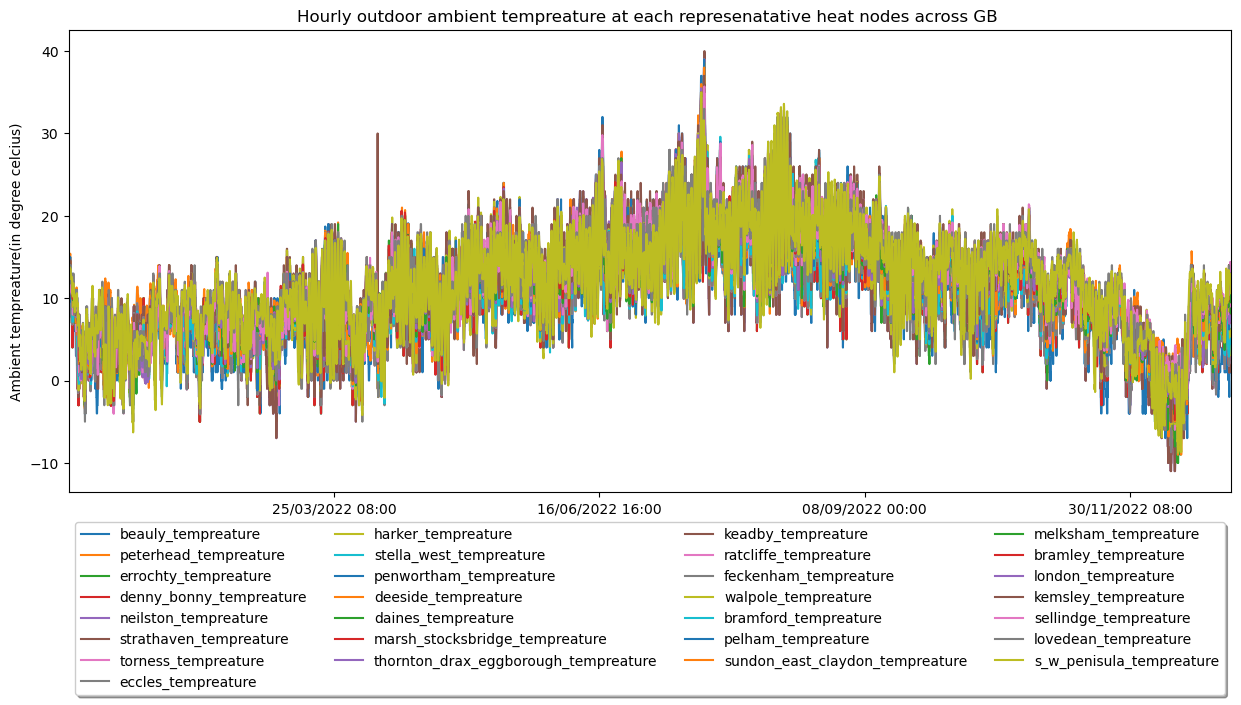

In [28]:
fig, ax= plt.subplots(1,1)
fig.set_size_inches(15,6)
temp_gb_clusteredNodes=pd.read_csv('data/gbNodes_temp.csv',index_col=0)
temp_gb_clusteredNodes.plot(ax=ax)

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)
#plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlim([1, 8760])
plt.title('Hourly outdoor ambient tempreature at each represenatative heat nodes across GB ')
plt.ylabel('Ambient tempreature(in degree celcius)')

In [29]:
temp_gb_clusteredNodes

,beauly_tempreature,peterhead_tempreature,errochty_tempreature,denny_bonny_tempreature,neilston_tempreature,strathaven_tempreature,torness_tempreature,eccles_tempreature,harker_tempreature,stella_west_tempreature,...,bramford_tempreature,pelham_tempreature,sundon_east_claydon_tempreature,melksham_tempreature,bramley_tempreature,london_tempreature,kemsley_tempreature,sellindge_tempreature,lovedean_tempreature,s_w_penisula_tempreature
time,,,,,,,,,,,,,,,,,,,,,
01/01/2022 00:00,5.0,8.1,11.0,11.0,11,11,10.4,10.4,11.6,10.2,...,11.0,13,12.3,12.6,12.8,11.8,12.8,12.3,12.0,13.7
01/01/2022 01:00,5.0,8.4,11.0,11.0,11,11,10.9,10.9,11.5,10.4,...,11.6,13,12.7,12.0,12.6,11.7,12.8,11.6,11.8,13.2
01/01/2022 02:00,5.0,8.8,12.0,12.0,11,11,10.7,10.7,11.6,10.5,...,11.7,13,12.3,11.6,12.5,11.6,12.5,12.0,11.8,13.2
01/01/2022 03:00,6.0,9.1,13.0,13.0,12,12,11.1,11.1,12.9,10.6,...,12.4,13,11.7,11.6,12.6,11.4,12.3,11.9,11.6,12.9
01/01/2022 04:00,9.0,9.9,13.0,13.0,12,12,11.4,11.4,12.5,10.4,...,12.6,13,11.6,11.7,12.4,11.3,12.1,11.9,11.3,13.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31/12/2022 19:00,1.0,1.2,4.0,4.0,3,3,3.2,3.2,6.0,4.9,...,12.1,12,12.3,10.7,12.5,12.3,13.1,13.6,13.0,11.9
31/12/2022 20:00,1.0,1.4,3.0,3.0,4,4,3.1,3.1,5.7,4.8,...,12.4,12,12.1,10.7,12.6,12.3,12.8,13.8,13.0,11.7
31/12/2022 21:00,1.0,1.6,3.0,3.0,3,3,3.2,3.2,5.8,5.1,...,12.8,13,12.1,10.4,11.8,12.1,12.7,12.4,11.9,11.4


Text(0, 0.5, 'Ambient tempreature(in degree celcius)')

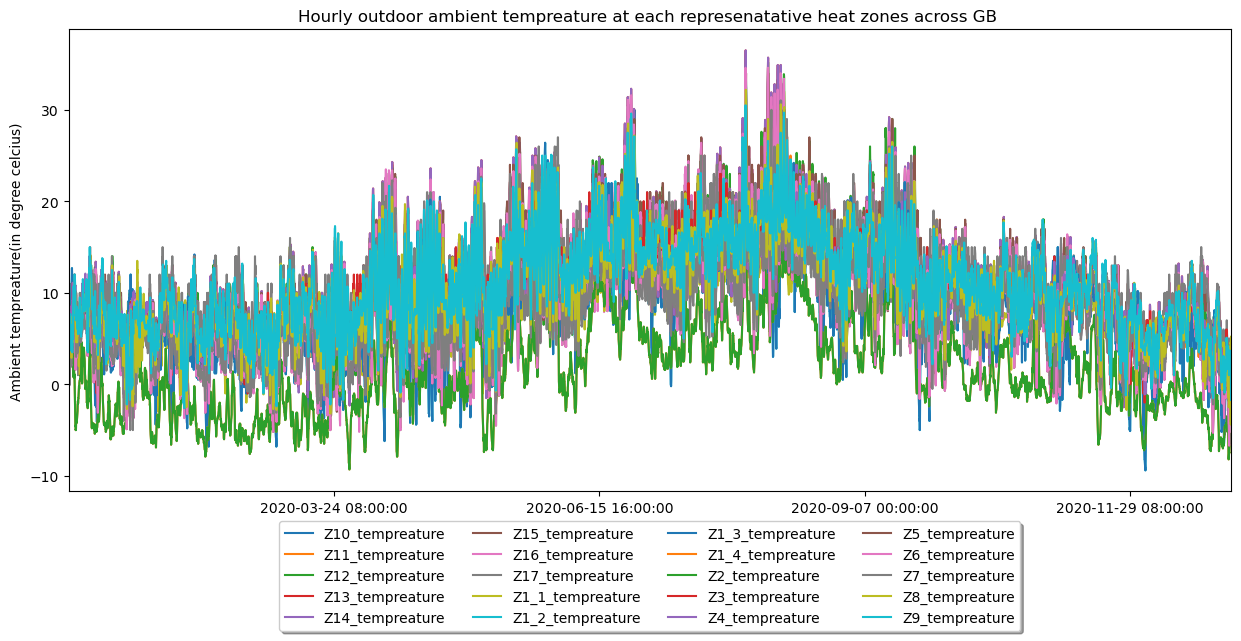

In [30]:
# tempreature data for the year 2020,extracted for the zonal model
fig, ax= plt.subplots(1,1)
fig.set_size_inches(15,6)
temp_gb_clusteredZones=pd.read_csv('data/gbZones_temp.csv',index_col=0)
temp_gb_clusteredZones.plot(ax=ax)

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)
#plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlim([1, 8760])
plt.title('Hourly outdoor ambient tempreature at each represenatative heat zones across GB ')
plt.ylabel('Ambient tempreature(in degree celcius)')

In [31]:
heat_demand_RHPP=pd.read_csv('data/domestic_RHPP/2035/scaled with normalised profiles/hourly heat demand total_withHPs_MW.csv',index_col=0)

Text(0, 0.5, 'Heat demand in kWh')

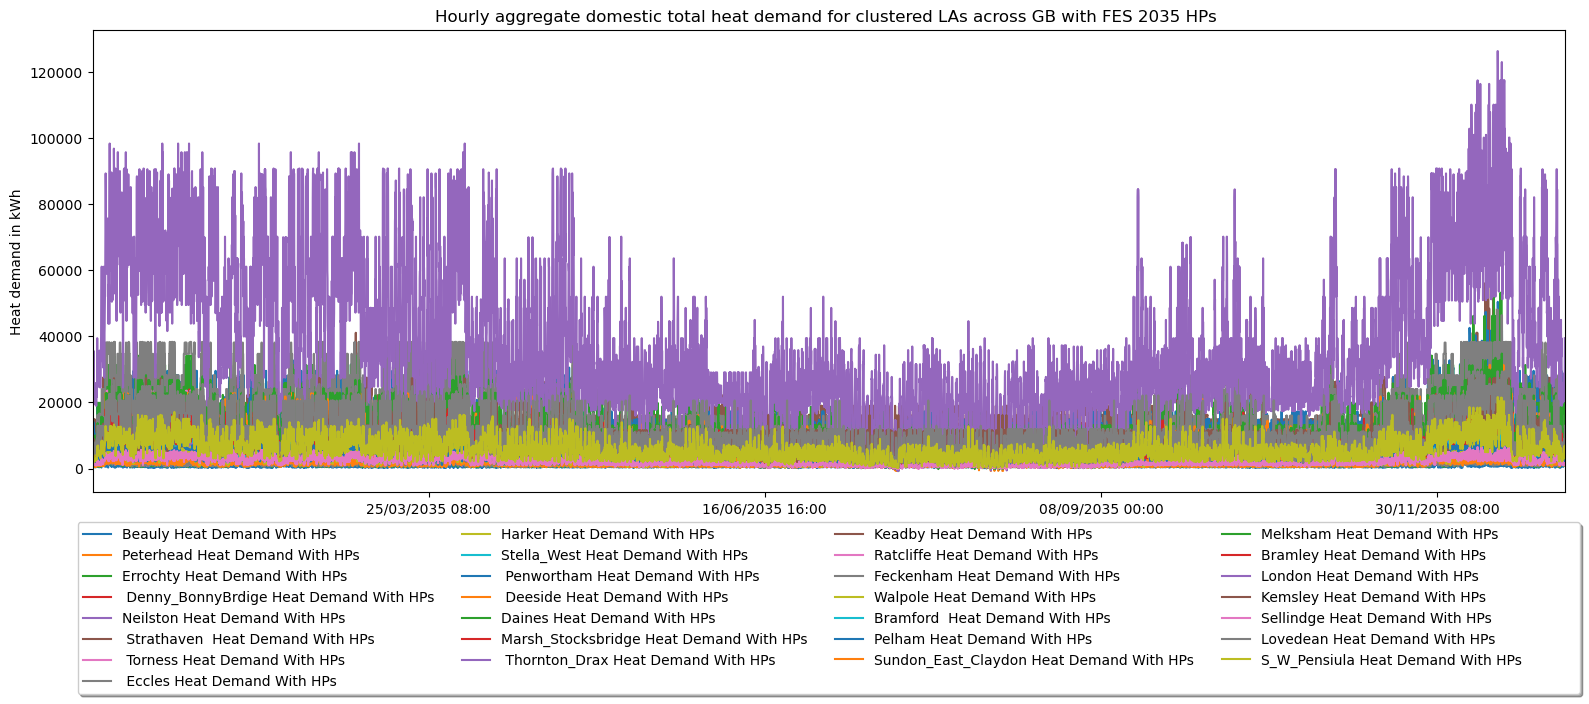

In [32]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(19,6)
heat_demand_RHPP.plot(ax=ax)
#plt.legend(bbox_to_anchor=(1.0, 1.0))
#plt.legend(loc=(1.0,1.0))
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)
plt.xlim([1, 8760])
plt.title('Hourly aggregate domestic total heat demand for clustered LAs across GB with FES 2035 HPs ')
plt.ylabel('Heat demand in kWh')


In [33]:
heat_demand_RHPP

,Beauly Heat Demand With HPs,Peterhead Heat Demand With HPs,Errochty Heat Demand With HPs,Denny_BonnyBrdige Heat Demand With HPs,Neilston Heat Demand With HPs,Strathaven Heat Demand With HPs,Torness Heat Demand With HPs,Eccles Heat Demand With HPs,Harker Heat Demand With HPs,Stella_West Heat Demand With HPs,...,Bramford Heat Demand With HPs,Pelham Heat Demand With HPs,Sundon_East_Claydon Heat Demand With HPs,Melksham Heat Demand With HPs,Bramley Heat Demand With HPs,London Heat Demand With HPs,Kemsley Heat Demand With HPs,Sellindge Heat Demand With HPs,Lovedean Heat Demand With HPs,S_W_Pensiula Heat Demand With HPs
Timestamp,,,,,,,,,,,,,,,,,,,,,
01/01/2035 00:00,298.633935,1119.197072,426.459291,3759.804199,637.566817,7069.859609,1333.016837,422.734298,758.505593,4468.696634,...,2334.039885,1209.817471,3462.652978,4109.550930,3093.793550,16771.97161,4276.982972,919.814928,4268.659025,2021.809521
01/01/2035 01:00,298.633935,1199.775306,426.459291,3759.804199,637.566817,7069.859609,1627.018489,515.969866,858.372994,4790.427001,...,2641.347436,1209.817471,3918.557530,4650.628245,3501.132828,18980.22588,4276.982972,1040.920859,4830.685047,2166.527830
01/01/2035 02:00,298.633935,1339.674940,558.987389,4928.215127,637.566817,7069.859609,1884.515263,597.628788,758.505593,6317.494858,...,3059.374920,1209.817471,3462.652978,5386.650471,4055.232499,21984.09275,5606.114327,1205.660083,4830.685047,2166.527830
01/01/2035 03:00,377.741149,1499.760328,629.617617,5550.914253,941.293362,10437.826650,2122.631087,673.141507,1119.845419,7115.734874,...,3445.938825,1209.817471,5112.204985,5386.650471,3501.132828,24761.86827,6314.468649,1357.999918,6302.179307,2826.482523
01/01/2035 04:00,448.393814,1647.363505,629.617617,5550.914253,941.293362,10437.826650,2290.484834,726.372295,1208.400727,4790.427001,...,3718.437305,1209.817471,5516.468716,6547.063562,4928.826377,26719.99109,6813.805171,1357.999918,6800.544010,3049.995542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31/12/2035 19:00,1019.946220,2991.733982,1469.744749,12957.749050,2495.233954,27669.184260,4302.362121,1364.390892,4036.517191,16483.876390,...,4912.858439,2221.948571,3462.652978,11914.903720,4055.232499,25887.74596,6030.280340,1099.088119,7839.811414,6474.806315
31/12/2035 20:00,1019.946220,3811.576625,1869.419432,16481.411410,2479.989466,27500.140980,3932.898036,1247.224225,4200.925044,17894.361510,...,3445.938825,2221.948571,6415.397158,11914.903720,3501.132828,25887.74596,4276.982972,1390.174840,7839.811414,3887.684106
31/12/2035 21:00,1019.946220,3168.929717,1869.419432,16481.411410,2495.233954,27669.184260,4302.362121,1364.390892,2809.572130,15624.297570,...,2762.581779,1209.817471,6415.397158,10874.194390,3995.894843,28937.83567,5977.093782,1399.090551,9084.531885,5202.673779


In [34]:
heat_demand_EDRP=pd.read_csv('data/domestic_EDRP/2035/scaled with normalised profiles/hourly heat demand total_withGasboilers_MW.csv',index_col=0)

In [35]:
heat_demand_EDRP

,Beauly Heat Demand With Gas Boilers,Peterhead Heat Demand With Gas Boilers,Errochty Heat Demand With Gas Boilers,Denny_Bonny/bridge Heat Demand With Gas Boilers,Neilston Heat Demand With Gas Boilers,Strathavenorness Heat Demand With Gas Boilers,Torness Heat Demand With Gas Boilers,Eccles Heat Demand With Gas Boilers,Harker Heat Demand With Gas Boilers,Stella_West Heat Demand With Gas Boilers,...,Bramford Heat Demand With Gas Boilers,Pelham Heat Demand With Gas Boilers,Sundon_East Heat Demand With Gas Boilers,Melksham Heat Demand With Gas Boilers,Bramley Heat Demand With Gas Boilers,London Heat Demand With Gas Boilers,Kemsley Heat Demand With Gas Boilers,Sellindge Heat Demand With Gas Boilers,Lovedean Heat Demand With Gas Boilers,S_W_Pensiula Heat Demand With Gas Boilers
Timestamp,,,,,,,,,,,,,,,,,,,,,
01/01/2035 00:00,266.905508,278.373230,130.215305,395.443504,2082.106519,0,937.721602,243.136855,300.439826,1806.716185,...,1688.032137,1439.776910,1572.234755,3124.138322,1866.718804,7805.553900,1349.994154,366.179705,2093.466993,1100.094649
01/01/2035 01:00,266.905508,243.201876,130.215305,395.443504,2082.106519,0,887.492978,230.113341,261.108435,1578.444758,...,1467.047281,1439.776910,1366.409247,2715.148917,1622.341592,6783.707708,1349.994154,318.242129,1819.405562,816.097448
01/01/2035 02:00,266.905508,245.420655,113.467690,344.583618,2082.106519,0,889.839552,230.721772,300.439826,1714.461432,...,1470.926225,1439.776910,1572.234755,2722.327903,1626.631142,6801.644161,1176.364928,319.083576,1819.405562,816.097448
01/01/2035 03:00,279.736005,296.811898,135.606995,411.817224,2168.318147,0,1063.461044,275.739167,312.879826,2048.979438,...,1757.926736,1439.776910,1637.334651,2722.327903,1622.341592,8128.750385,1405.891963,381.341729,2180.149013,977.909534
01/01/2035 04:00,494.556303,529.538480,135.606995,411.817224,2168.318147,0,1899.053265,492.395437,558.718590,1578.444758,...,3139.180814,1439.776910,2923.836028,5809.862777,3471.478845,14515.745580,2510.542100,381.341729,3893.155393,1746.281448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31/12/2035 19:00,3739.872047,1036.191394,1641.806306,4985.908829,34365.231130,0,6576.608853,1705.213987,5910.068245,17671.937840,...,14378.973860,6704.144718,1572.234755,22874.183920,1626.631142,62260.635160,10320.778100,1120.747665,9747.972474,11972.005100
31/12/2035 20:00,3739.872047,2102.094831,2547.774203,7737.191559,36183.255540,0,9725.613897,2521.702784,7511.011539,29155.725860,...,1757.926736,6704.144718,8773.499293,22874.183920,1622.341592,62260.635160,1349.994154,2890.067679,9747.972474,4738.641846
31/12/2035 21:00,3739.872047,736.033312,2547.774203,7737.191559,34365.231130,0,6576.608853,1705.213987,3464.883479,30138.243800,...,4983.852045,1439.776910,8773.499293,17777.733880,5694.906786,33057.374730,6494.295260,3022.865739,3131.580000,2962.620721


Text(0, 0.5, 'Heat demand in MWh')

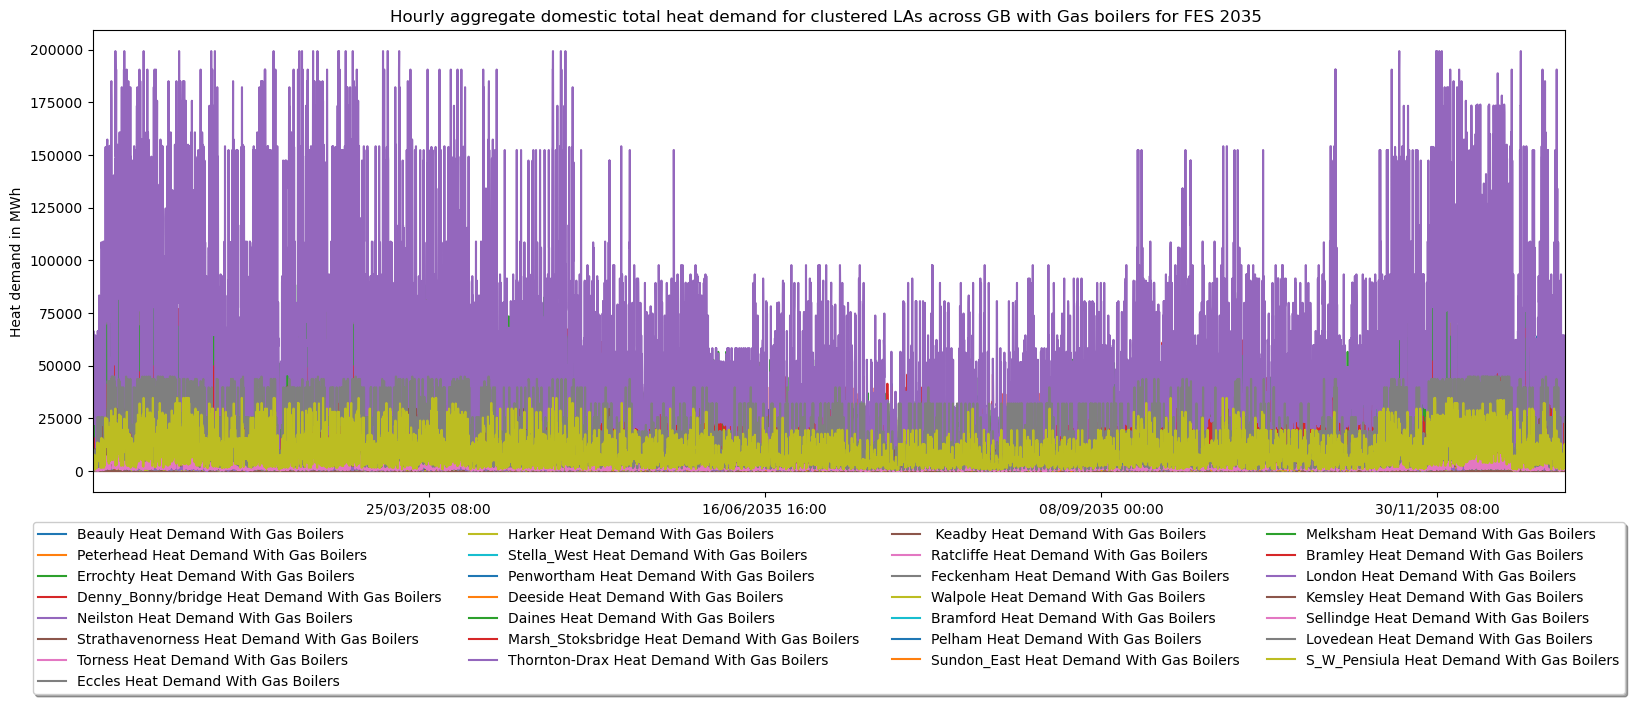

In [36]:
# plotting the heat demand profile for the gas boiler using both the CLA and FES data
fig, ax = plt.subplots(1,1)
fig.set_size_inches(19,6)
heat_demand_EDRP.plot(ax=ax)
#plt.legend(bbox_to_anchor=(1.0, 1.0))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)
plt.xlim([1, 8760])
plt.title('Hourly aggregate domestic total heat demand for clustered LAs across GB with Gas boilers for FES 2035 ')
plt.ylabel('Heat demand in MWh')


Text(0, 0.5, 'Heat demand in MWh')

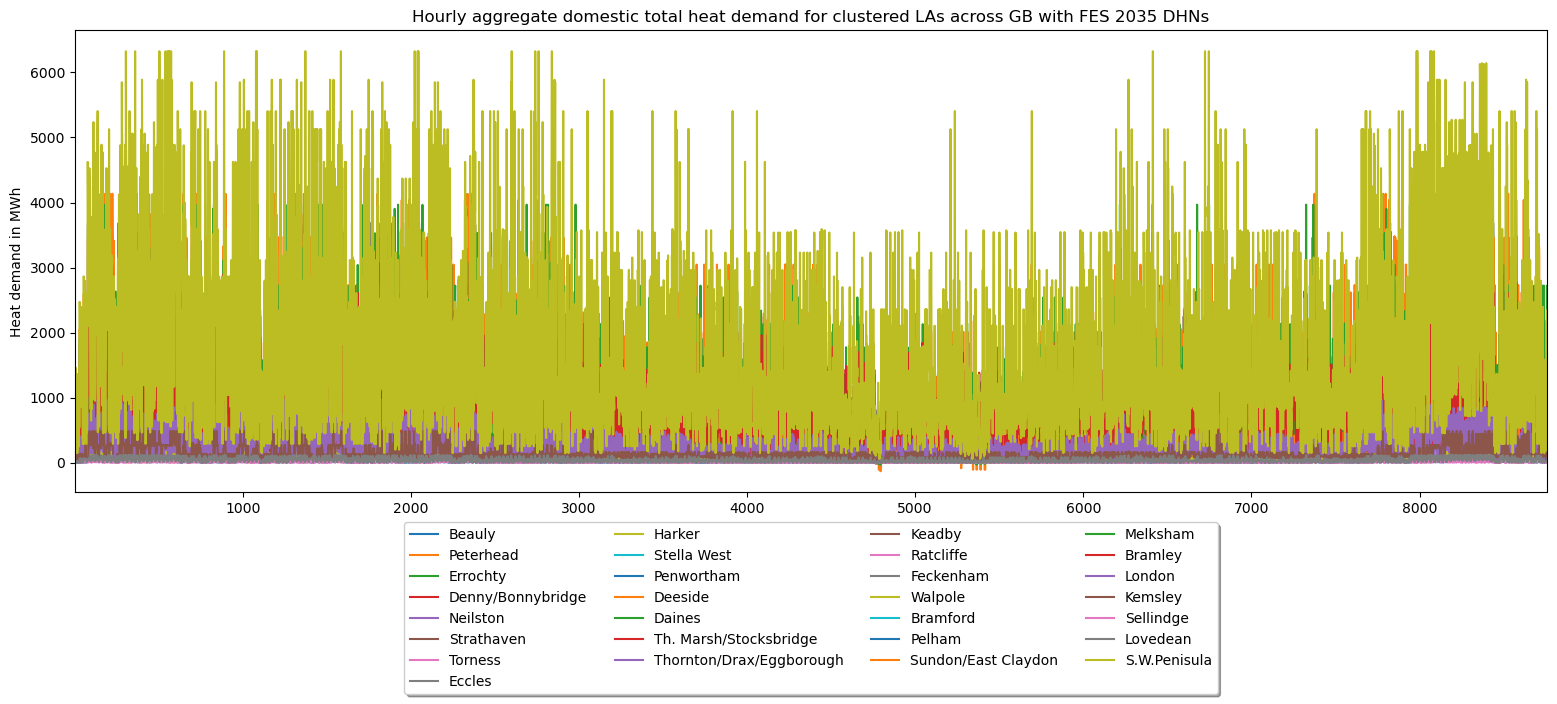

In [37]:
# plotting the heat demand profile for the DHN using both the CLA and FES data
fig, ax = plt.subplots(1,1)
fig.set_size_inches(19,6)

heating_EDRP_DHN=pd.read_csv('data/domestic_EDRP_DHN/2035/scaled with normalised profiles/hourly heat demand total_withDHN_MW.csv')

heating_EDRP_DHN.plot(ax=ax)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)
plt.xlim([1, 8760])
plt.title('Hourly aggregate domestic total heat demand for clustered LAs across GB with FES 2035 DHNs')
plt.ylabel('Heat demand in MWh')


Text(0, 0.5, 'Heat demand in MWh')

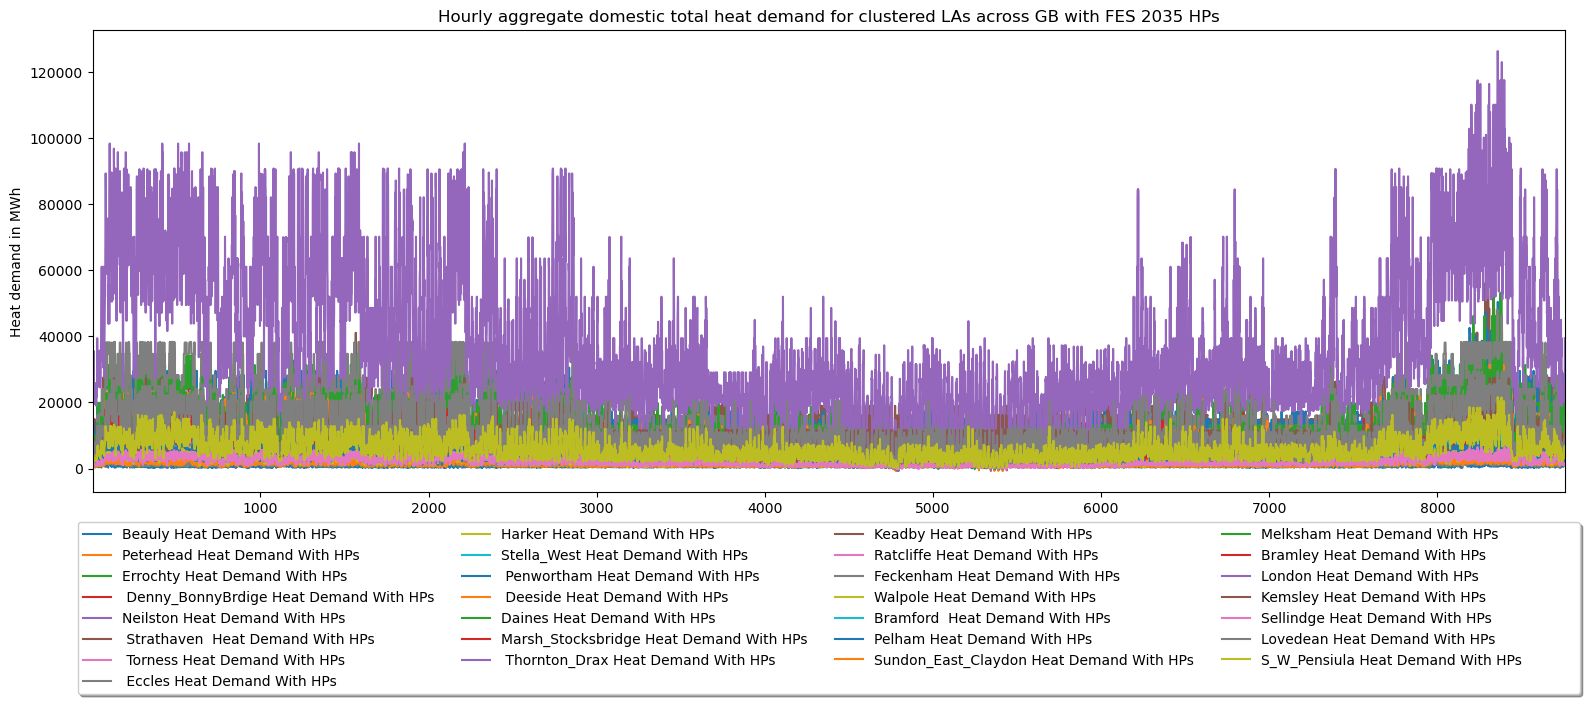

In [38]:
# plotting the heat demand profile for the HPs using both the CLA and FES data
fig, ax = plt.subplots(1,1)
fig.set_size_inches(19,6)

heating_RHPP=pd.read_csv('data/domestic_RHPP/2035/scaled with normalised profiles/hourly heat demand total_withHPs_MW.csv')

heating_RHPP.plot(ax=ax)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)
plt.xlim([1, 8760])
plt.title('Hourly aggregate domestic total heat demand for clustered LAs across GB with FES 2035 HPs')
plt.ylabel('Heat demand in MWh')

Disaggregating the heat pump profile to GSHP and ASHP with 25% and 75 % proportion, respectively. This part is only implemented for FES 2022. 

Text(0, 0.5, 'Heat demand in MWh')

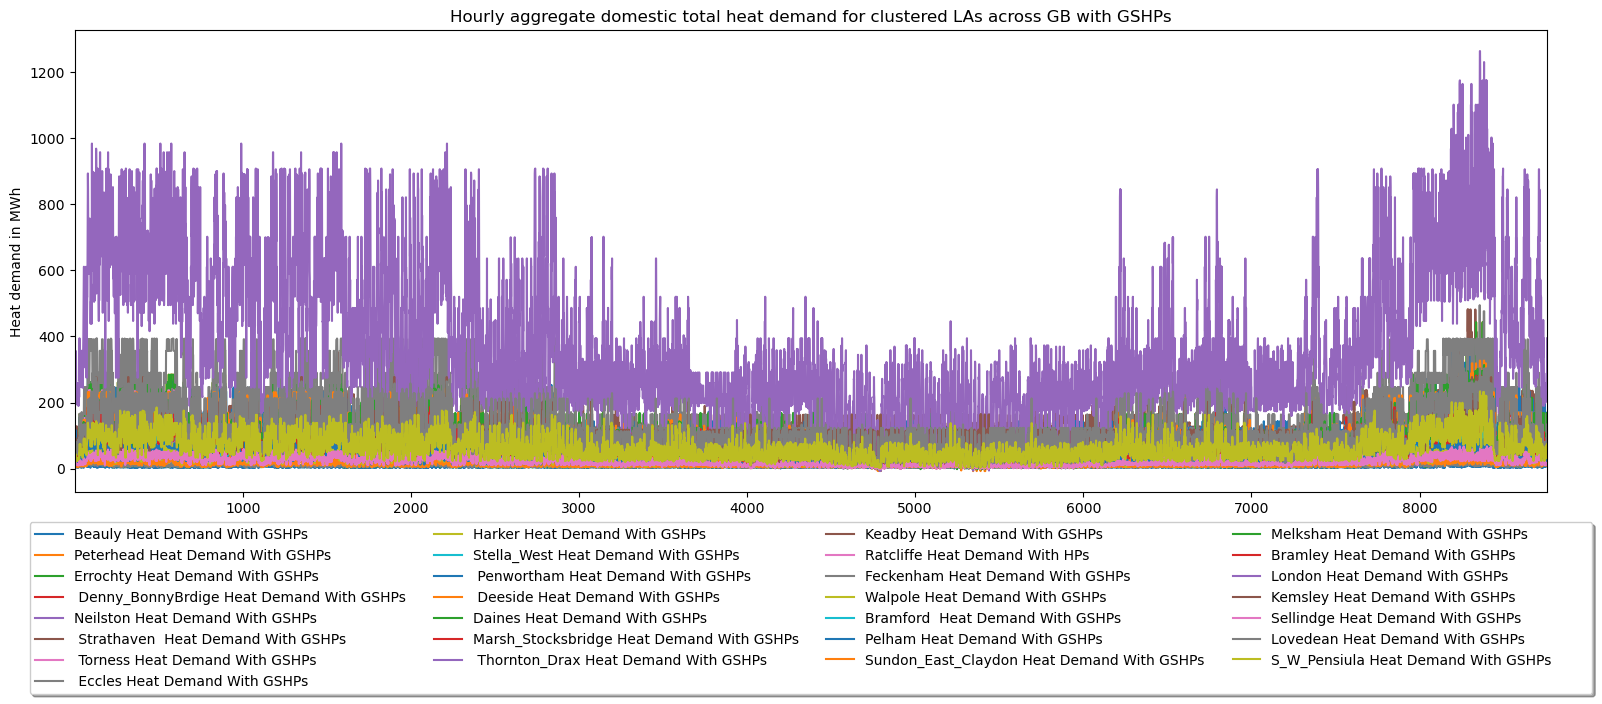

In [39]:
# plotting the heat demand profile for the GSHPs using both the CLA and FES data
fig, ax = plt.subplots(1,1)
fig.set_size_inches(19,6)

heating_GSHP=pd.read_csv('data/domestic_RHPP/GSHP/scaled with normalised profiles/hourly heat demand total_withGSHPs_MW.csv')

heating_GSHP.plot(ax=ax)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)
plt.xlim([1, 8760])
plt.title('Hourly aggregate domestic total heat demand for clustered LAs across GB with GSHPs')
plt.ylabel('Heat demand in MWh')

Text(0, 0.5, 'Heat demand in MWh')

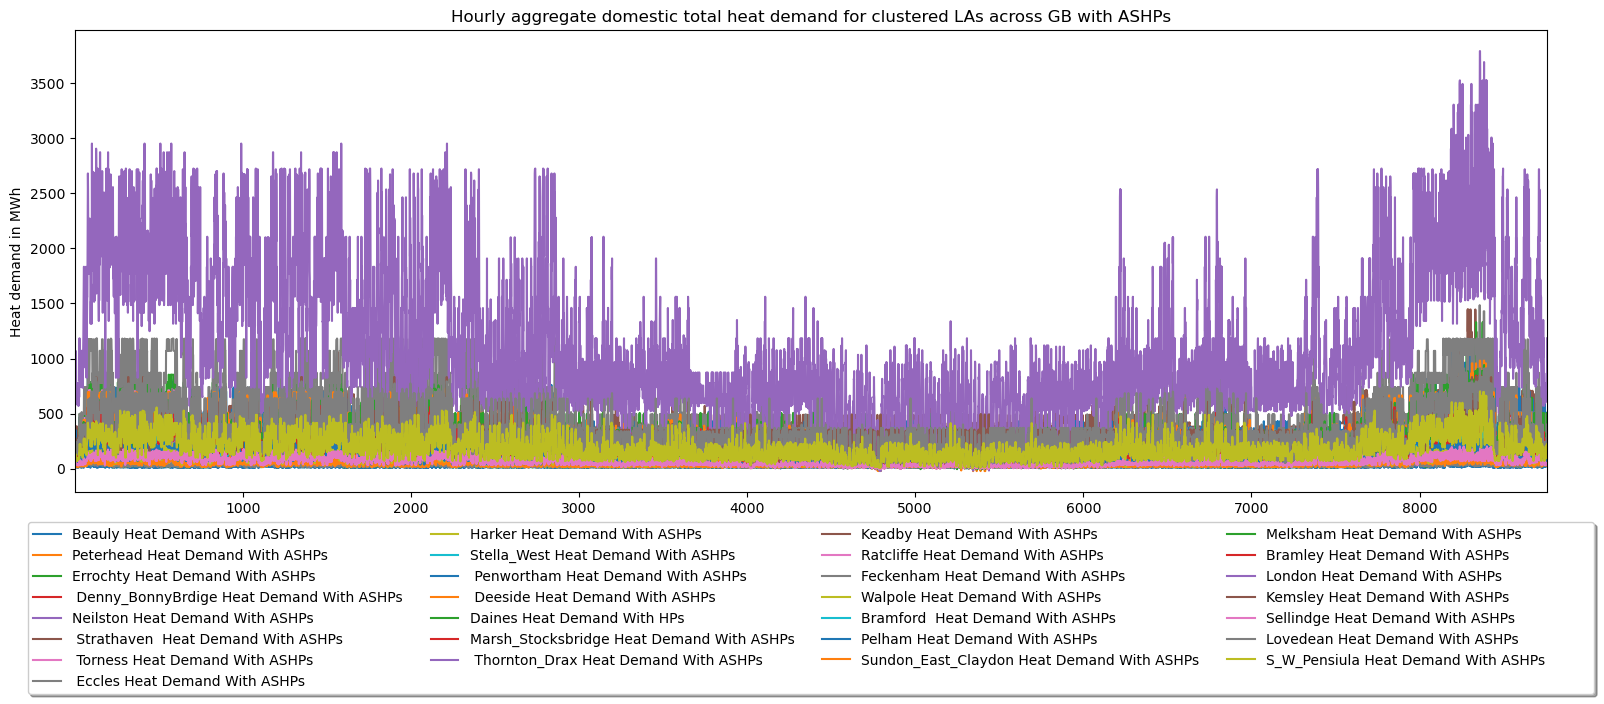

In [40]:
# plotting the heat demand profile for the ASHPs using both the CLA and FES data
fig, ax = plt.subplots(1,1)
fig.set_size_inches(19,6)

heating_ASHP=pd.read_csv('data/domestic_RHPP/ASHP/scaled with normalised profiles/hourly heat demand total_withASHPs_MW.csv')

heating_ASHP.plot(ax=ax)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)
plt.xlim([1, 8760])
plt.title('Hourly aggregate domestic total heat demand for clustered LAs across GB with ASHPs')
plt.ylabel('Heat demand in MWh')

In [41]:
COP_profiles=pd.read_csv('data/domestic_RHPP/COP/hourly COP_HPs.csv',index_col=0)

In [42]:
COP_profiles

,Beauly COP,Peterhead COP,Errochty COP,Denny_bonny COP,Neilston COP,Strathaven COP,Torness COP,Eccles COP,Harker COP,Stella_West COP,...,Bramford COP,Pelham COP,Sundon_East_Claydon COP,Melksham COP,Bramley COP,london COP,Kemsley COP,Sellindge COP,Lovedean COP,S_W_Penisula COP
Timestamp,,,,,,,,,,,,,,,,,,,,,
01/01/2022 00:00,2.395,2.5345,2.665,2.665,2.665,2.665,2.6380,2.6380,2.6920,2.6290,...,2.6650,2.755,2.7235,2.7370,2.7460,2.7010,2.7460,2.7235,2.7100,2.7865
01/01/2022 01:00,2.395,2.5480,2.665,2.665,2.665,2.665,2.6605,2.6605,2.6875,2.6380,...,2.6920,2.755,2.7415,2.7100,2.7370,2.6965,2.7460,2.6920,2.7010,2.7640
01/01/2022 02:00,2.395,2.5660,2.710,2.710,2.665,2.665,2.6515,2.6515,2.6920,2.6425,...,2.6965,2.755,2.7235,2.6920,2.7325,2.6920,2.7325,2.7100,2.7010,2.7640
01/01/2022 03:00,2.440,2.5795,2.755,2.755,2.710,2.710,2.6695,2.6695,2.7505,2.6470,...,2.7280,2.755,2.6965,2.6920,2.7370,2.6830,2.7235,2.7055,2.6920,2.7505
01/01/2022 04:00,2.575,2.6155,2.755,2.755,2.710,2.710,2.6830,2.6830,2.7325,2.6380,...,2.7370,2.755,2.6920,2.6965,2.7280,2.6785,2.7145,2.7055,2.6785,2.7595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31/12/2022 19:00,2.215,2.2240,2.350,2.350,2.305,2.305,2.3140,2.3140,2.4400,2.3905,...,2.7145,2.710,2.7235,2.6515,2.7325,2.7235,2.7595,2.7820,2.7550,2.7055
31/12/2022 20:00,2.215,2.2330,2.305,2.305,2.350,2.350,2.3095,2.3095,2.4265,2.3860,...,2.7280,2.710,2.7145,2.6515,2.7370,2.7235,2.7460,2.7910,2.7550,2.6965
31/12/2022 21:00,2.215,2.2420,2.305,2.305,2.305,2.305,2.3140,2.3140,2.4310,2.3995,...,2.7460,2.755,2.7145,2.6380,2.7010,2.7145,2.7415,2.7280,2.7055,2.6830


Text(0, 0.5, 'Heat pump COP')

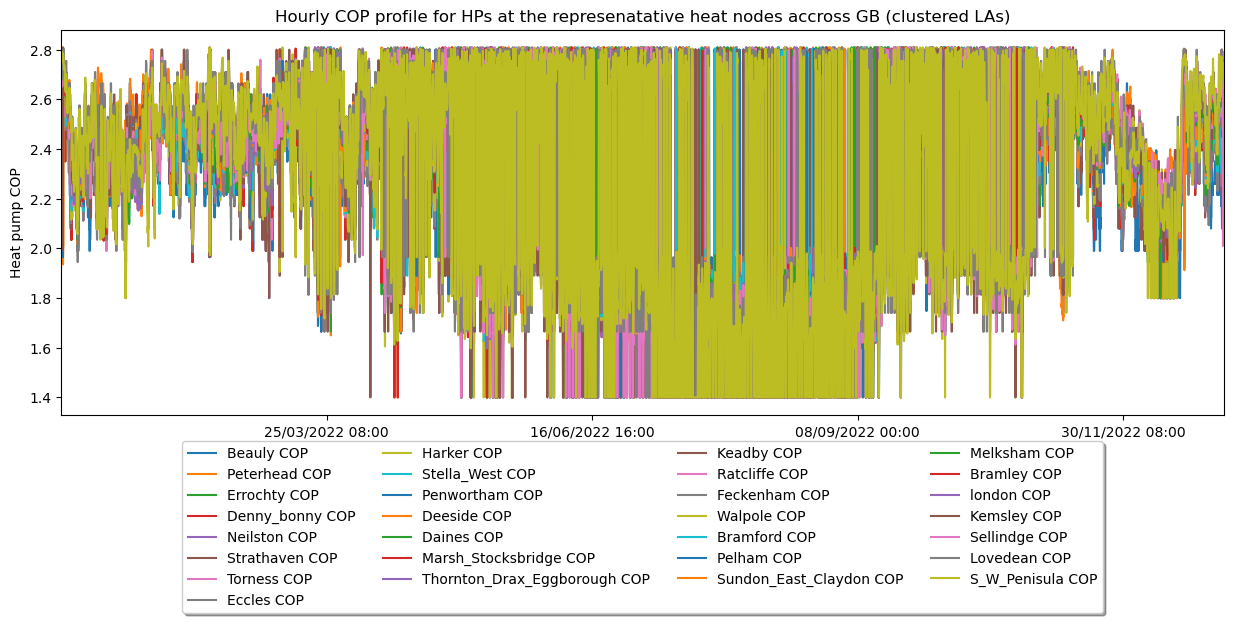

In [43]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15,5)
COP_profiles.plot(ax=ax)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)
#plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlim([1, 8760])
plt.title('Hourly COP profile for HPs at the represenatative heat nodes accross GB (clustered LAs)')
plt.ylabel('Heat pump COP')